In [1]:
#
# Chapter 10, Example 3c: sparse AE
#

import os
import pylab
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models, losses

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [2]:
# Load and prepare the MNIST dataset. 
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()
# Normalize image to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Built Model
seed = 10
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float32')
class Autoencoder(Model):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Initialize the weights and biases
        self.W = tf.Variable(tf.keras.backend.truncated_normal([n_input, n_hidden], stddev=1/np.sqrt(n_input)))
        self.b = tf.Variable(tf.zeros([n_hidden]))
        self.b_prime = tf.Variable(tf.zeros([n_input]))

    def call(self, x):
        h = tf.sigmoid(tf.matmul(x, self.W) + self.b)
        y = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.b_prime)
        return h,y

# Intialize an AE with 900 hidden units
autoencoder = Autoencoder(n_input=28*28,n_hidden=900)

In [4]:
# Set an optimizer and loss function for training
optimizer = tf.optimizers.SGD(learning_rate=0.1)
def loss(h,y,original):
    rho = 0.05
    mse_loss = tf.reduce_mean(tf.reduce_sum(tf.square(original - y), axis=1))
    sparse_loss = tf.reduce_sum(rho*tf.math.log(rho/tf.reduce_mean(h, axis=0)) + (1 - rho)*tf.math.log((1 - rho)/(1-tf.reduce_mean(h, axis=0))))
    return mse_loss + 0.5*sparse_loss

In [5]:
# Training function
def train(original):
    with tf.GradientTape() as tape:
        h, y = autoencoder(original)
        losses = loss(h, y, original)
        trainable_variables = [autoencoder.W,autoencoder.b,autoencoder.b_prime]
        gradients = tape.gradient(losses, trainable_variables)
        gradient_variables = zip(gradients, trainable_variables)
        optimizer.apply_gradients(gradient_variables)
    return losses

In [6]:
# Vectorize iamges 
x_train = tf.cast(x_train.reshape(x_train.shape[0],28*28), tf.float32)
x_test = tf.cast(x_test.reshape(x_test.shape[0],28*28), tf.float32)
# Use tf.data to batch and shuffle the train dataset
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

In [7]:
# Main function: train the model
no_epochs = 50
print('Training starts...')
l = [] 
for i in range(no_epochs):
    l_ = []
    for images in train_ds:
        l_.append(train(images))
    l.append(np.mean(l_))
    if i%1 == 0:
        print('epoch: %d, loss: %f'%(i, l[i]))

Training starts...
epoch: 0, loss: 45.298965
epoch: 1, loss: 24.762812
epoch: 2, loss: 19.151167
epoch: 3, loss: 16.057619
epoch: 4, loss: 14.106604
epoch: 5, loss: 12.761198
epoch: 6, loss: 11.762214
epoch: 7, loss: 10.991500
epoch: 8, loss: 10.376458
epoch: 9, loss: 9.856777
epoch: 10, loss: 9.423953
epoch: 11, loss: 9.064830
epoch: 12, loss: 8.745966
epoch: 13, loss: 8.476779
epoch: 14, loss: 8.230497
epoch: 15, loss: 8.011096
epoch: 16, loss: 7.813523
epoch: 17, loss: 7.620555
epoch: 18, loss: 7.476630
epoch: 19, loss: 7.319436
epoch: 20, loss: 7.160209
epoch: 21, loss: 7.048711
epoch: 22, loss: 6.921576
epoch: 23, loss: 6.811378
epoch: 24, loss: 6.709689
epoch: 25, loss: 6.605077
epoch: 26, loss: 6.523322
epoch: 27, loss: 6.441206
epoch: 28, loss: 6.338740
epoch: 29, loss: 6.259413
epoch: 30, loss: 6.192061
epoch: 31, loss: 6.124537
epoch: 32, loss: 6.052464
epoch: 33, loss: 5.989979
epoch: 34, loss: 5.933497
epoch: 35, loss: 5.872895
epoch: 36, loss: 5.828591
epoch: 37, loss: 5.7

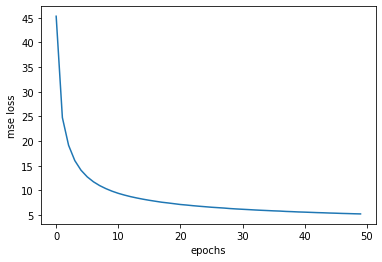

In [8]:
# Plot the loss curve
pylab.figure()
pylab.plot(range(no_epochs), l)
pylab.xlabel('epochs')
pylab.ylabel('mse loss')
pylab.savefig('./figures/10.3c_1.png')

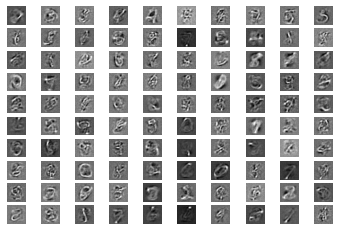

In [9]:
# Show the weights of autoencoder
pylab.figure()
pylab.gray()
for i in range(100):
    pylab.subplot(10, 10, i+1); pylab.axis('off'); pylab.imshow(np.array(autoencoder.W[:,i]).reshape(28,28))
pylab.savefig('./figures/10.3c_2.png')

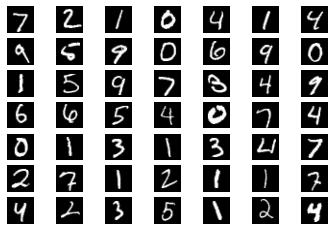

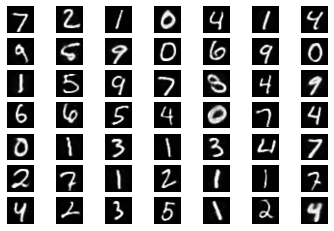

In [10]:
# Show test input image
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test[i,:]).reshape(28,28))
pylab.savefig('./figures/10.3c_3.png')

# Show reconstructed image
_,x_test_out = autoencoder(tf.cast(x_test, tf.float32))
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test_out[i,:]).reshape(28,28))
pylab.savefig('./figures/10.3c_4.png')

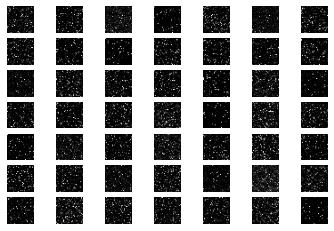

In [11]:
# Hidden layer activations of 49 test patterns
h = tf.sigmoid(tf.matmul(tf.cast(x_test, tf.float32), autoencoder.W) + autoencoder.b)
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(h[i,:]).reshape(30,30))
pylab.savefig('./figures/10.3c_5.png')